In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:158: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:42: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:46: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:49: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [5]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

tsmom_model.py:273: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:273: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [6]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


In [7]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)

tsmom_model.py:238: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:239: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [8]:
factors=pd.DataFrame()
for s in ['Agriculturals',
         'Energies',
         'Equities',
         'Metals',
         'Fixed Income']:
    factors[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']


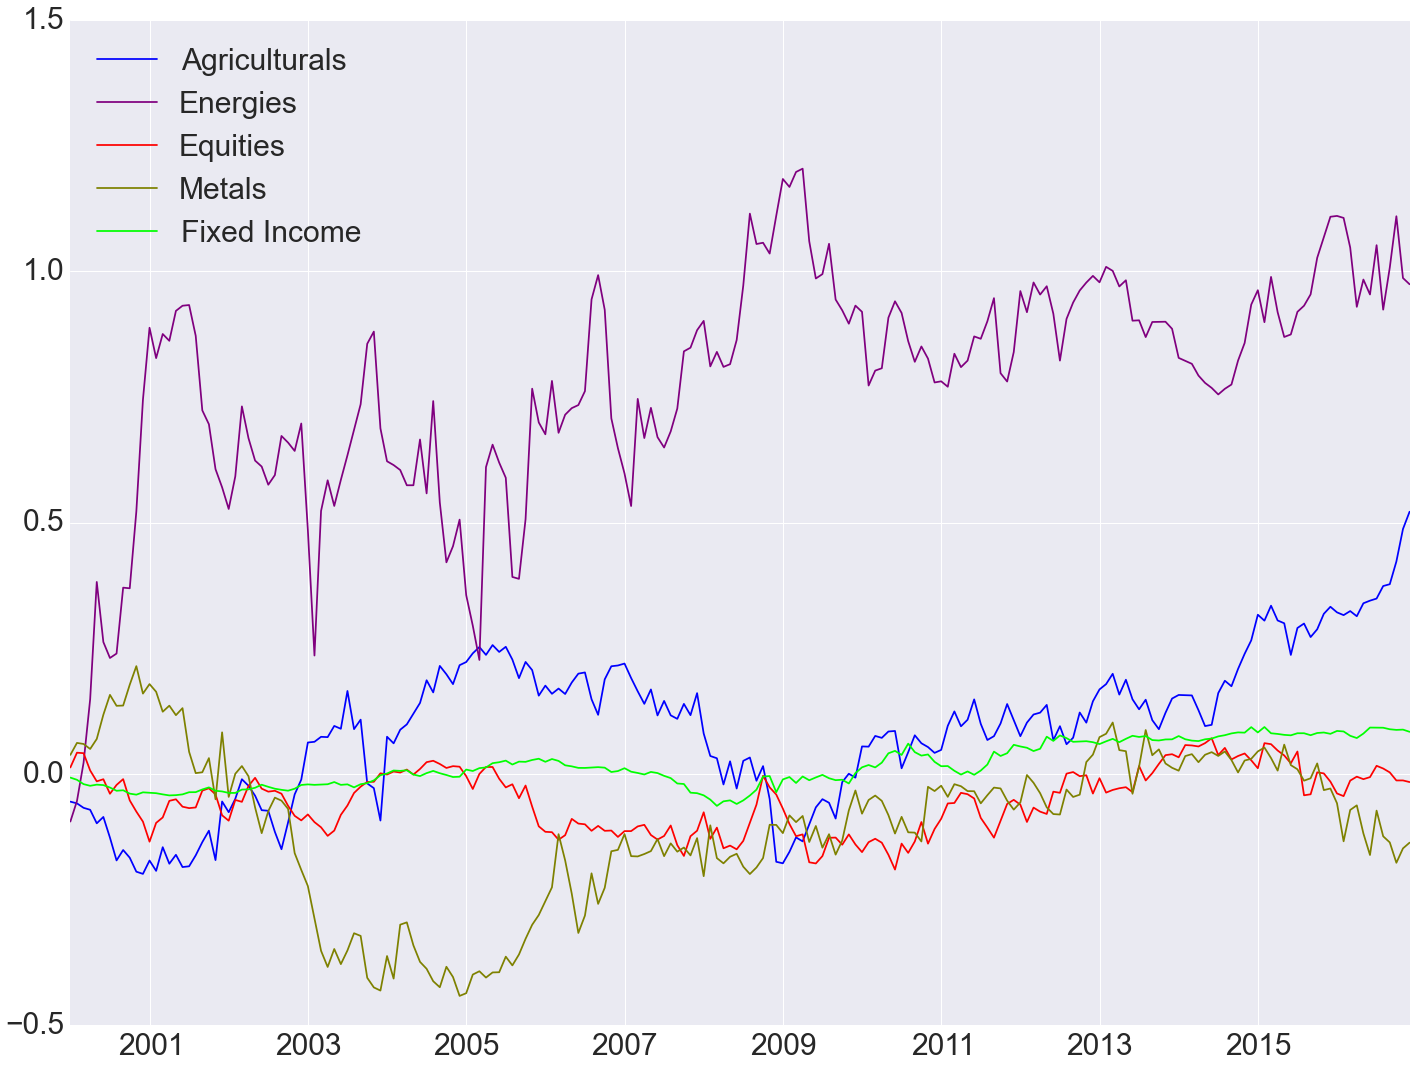

In [9]:
factors.cumsum().plot(colormap='brg')

In [14]:
final_res=pd.DataFrame()
alpha=[]
tstat=[]
for sec in factors.columns:
    ind=factors.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha.append(res.params.const)
    tstat.append(res.tvalues.const)
final_res['alpha1']=pd.Series(alpha)*100
final_res['tstat']=pd.Series(tstat)

In [15]:
final_res

,alpha1,tstat
0,0.315777,1.349242
1,0.624799,1.021351
2,-0.012194,-0.074674
3,-0.124955,-0.504142
4,0.047579,0.879938


# FHT Annual portfolio sorts

In [16]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

tsmom_model.py:283: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:284: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:285: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:285: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [18]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)

In [20]:
factors_FHT=pd.DataFrame()
for s in sector_zscores.keys():
    factors_FHT[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']


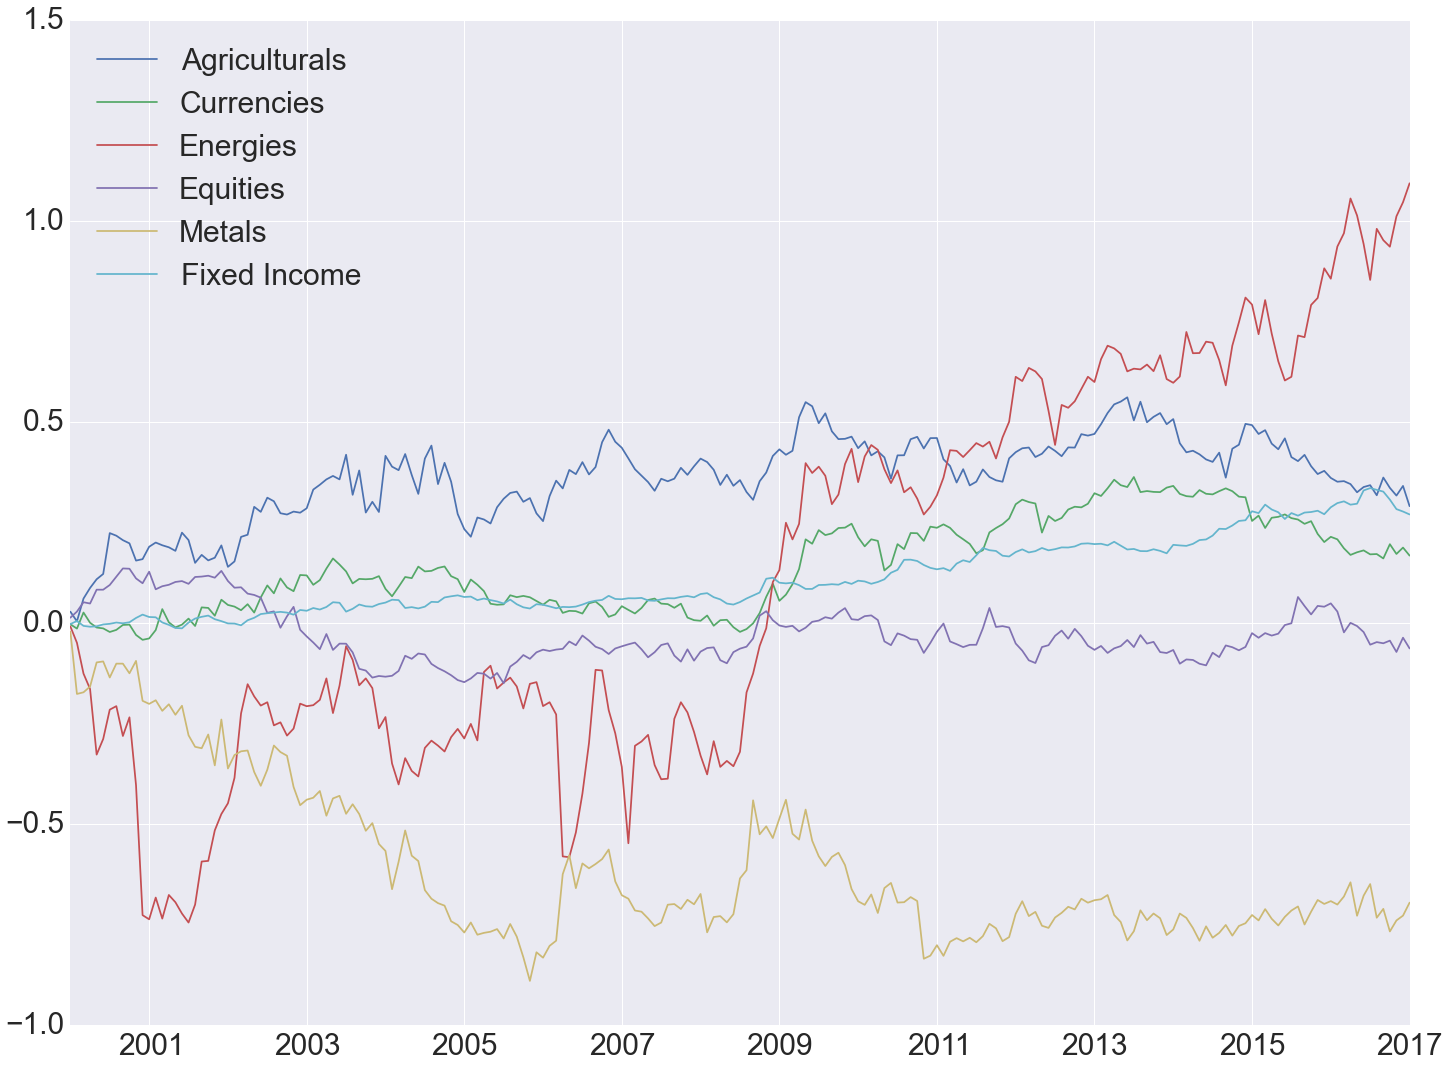

In [21]:
factors_FHT['2000':].cumsum().plot()

In [22]:
alpha=[]
tstat=[]
for sec in factors_FHT.columns:
    ind=factors_FHT.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_FHT[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha.append(res.params.const)
    tstat.append(res.tvalues.const)
final_res['alpha F-A']=pd.Series(alpha)*100
final_res['tstat2']=pd.Series(tstat)

In [23]:
final_res

,alpha1,tstat,alpha F-A,tstat2
0,0.315777,1.349242,0.174634,0.846880
1,0.624799,1.021351,NaN,NaN
2,-0.012194,-0.074674,0.587644,1.394696
3,-0.124955,-0.504142,0.121033,0.566765
4,0.047579,0.879938,0.051990,0.211917


# Monthly portoflio sorts

In [17]:
amihud_monthly = read_monthly(amihud=True)

In [18]:
factors_monthly=pd.DataFrame()
for s in ['Commodities', 'Equities', 'Fixed Income']:
    factors_monthly[s]=amihud_monthly[s]['2']-amihud_monthly[s]['0']


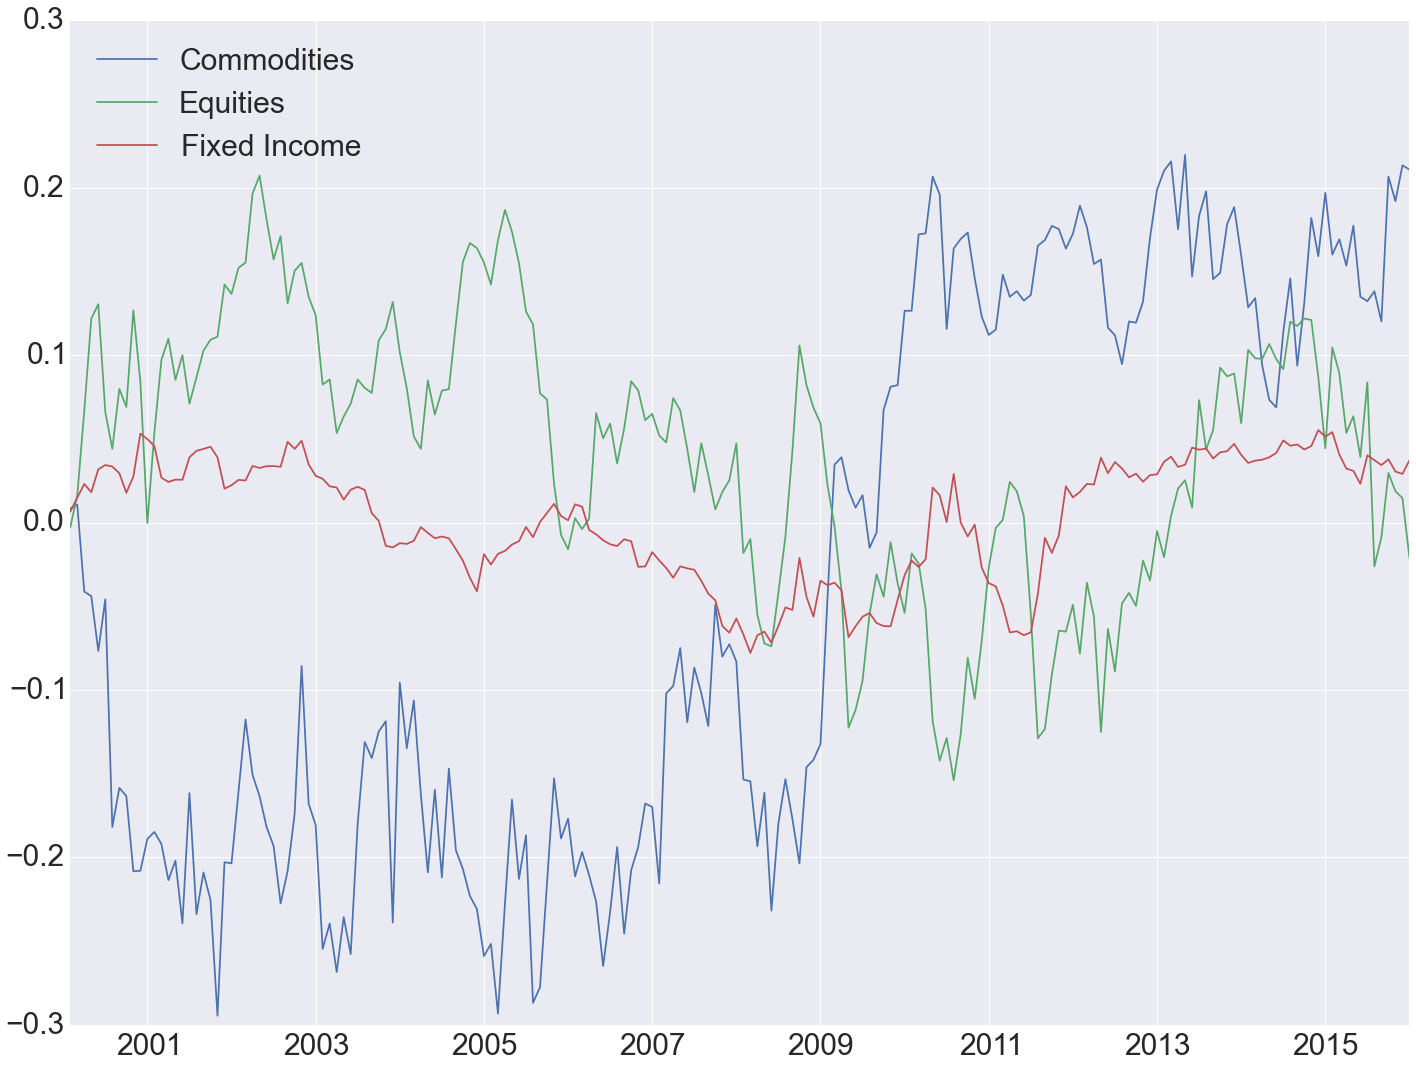

In [19]:
factors_monthly.cumsum().plot()

In [20]:
alpha=[]
tstat=[]
for sec in factors_monthly.columns:
    ind=factors_monthly.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha.append(res.params.const)
    tstat.append(res.tvalues.const)
final_res['alpha A-M']=pd.Series(alpha)*100
final_res['tstat3']=pd.Series(tstat)

KeyError: 'Commodities'

# Monthly FHT

In [ ]:
FHT_monthly = read_monthly(amihud=False)

In [ ]:
factors_monthly_FHT=pd.DataFrame()
for s in ['Commodities', 'Equities', 'Fixed Income']:
    factors_monthly_FHT[s]=FHT_monthly[s]['2']-FHT_monthly[s]['0']


In [ ]:
factors_monthly_FHT.cumsum().plot()

In [ ]:
alpha=[]
tstat=[]
for sec in factors_monthly_FHT.columns:
    ind=factors_monthly_FHT.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly_FHT[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha.append(res.params.const)
    tstat.append(res.tvalues.const)
final_res['alpha F-M']=pd.Series(alpha)*100
final_res['tstat4']=pd.Series(tstat)

In [25]:
df=final_res.set_index(factors.columns)

# Alpha values 

$$r_{liquidity,t} = \alpha + \beta_1 r_{AssetClass,t} + \beta_2 MOM_{AssetClass,t} +
\beta_3 VAL_{AssetClass,t} + \varepsilon_t $$

In [26]:
print(df.T.round(2).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Agriculturals &  Energies &  Equities &  Metals &  Fixed Income \\
\midrule
alpha1    &           0.32 &      0.62 &     -0.01 &   -0.12 &          0.05 \\
tstat     &           1.35 &      1.02 &     -0.07 &   -0.50 &          0.88 \\
alpha F-A &           0.17 &       NaN &      0.59 &    0.12 &          0.05 \\
tstat2    &           0.85 &       NaN &      1.39 &    0.57 &          0.21 \\
\bottomrule
\end{tabular}

